In [1]:
from PIL import Image
import numpy as np
import math
import cv2
import glob
from scipy import ndimage
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import scipy.misc
from skimage import exposure
import os 


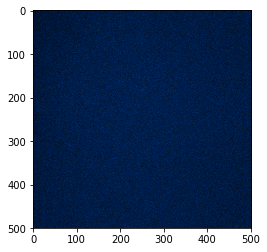

In [88]:
# First let's see a sample slice 
im = Image.open('/Users/mojtaba/Desktop/Toxoplasma/3d_video/t00/010t01z01.tif')
plt.imshow(im)
plt.show()
im = np.asarray(im)

In [2]:
# Here , I import all slices of frame 0 and put them on "images" as a numpy array
images = [cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob('/Users/mojtaba/Desktop/Toxoplasma/3d_video/t00/*.tif'))]

In [3]:
path = '/Users/mojtaba/Desktop/Toxoplasma/3d_video/t00'
extension = '*.tif'
images2 = [cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob(os.path.join(path,extension)))]

In [4]:
'''ok! but it's better to read all the slices of different frams at once 
and converting the "*.tif" files into grayscale and finally converting
them into numpy array'''

directory_list = list()
for root, dirs, files in os.walk('/Users/mojtaba/Desktop/Toxoplasma/3d_video/' , topdown=False):
    for name in dirs:
        if not (name.startswith('.')):
            directory_list.append(os.path.join(root, name))

sorted_path = sorted(directory_list)

all_images = list ()
extension = '*.tif'
for i in range(len(sorted_path)):
    all_images.append([cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in sorted(glob.glob(os.path.join(sorted_path[i],extension)))]) 
print(len(all_images))

63


In [5]:
#Now let's see the dimensions of our giant numpy array
all_ims = np.asarray(all_images)
np.shape(all_ims)

(63, 41, 500, 502)

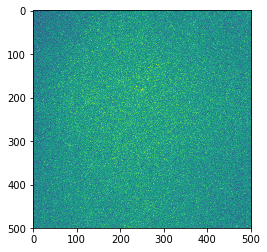

In [7]:
# Let's visualize a sample stored frame
plt.imshow(all_ims[0][0])
plt.show()

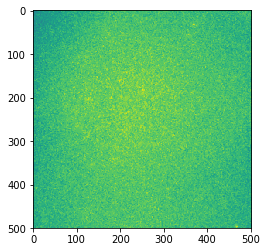

In [9]:
'''
# The above image is too noisy ! The noise seems to be salt& pepper 
# noise! let apply a soft median filter which is the best for this 
# kind of noise. We can apply the mean for removing the noise better but
# the issue is, it will destroy the valuable cell informations too! 
'''
im_med = ndimage.median_filter(all_ims[0][0], 3)
plt.imshow(im_med)
plt.show()

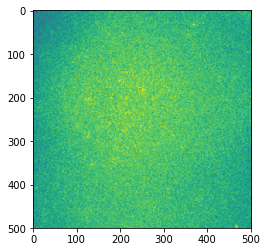

In [10]:
'''
in above image you can see the effect of dark corners! we will work on 
removing that effect later using deep learning and probably GAN models 
Now let's just apply a bilateral filter on median image to see the results
on the intensity map
'''
blur = cv2.bilateralFilter(im_med,3,75,75)
plt.imshow(blur)
plt.show()

In [12]:
''' Ok! Let's plot the 3d intensity map of the normal image and 
the blured one to compare them and have better understanding about
the signal and noises in both cases! 
''' 
img9 = scipy.misc.imresize(all_ims[0][4], 0.2, interp='cubic')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img9.shape[0], 0:img9.shape[1]]

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


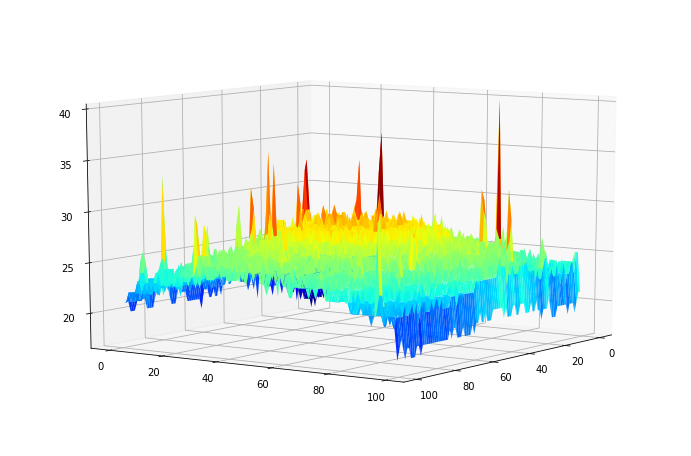

In [14]:
# create the figure
fig = plt.figure(figsize =(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img9 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(10, 35)
fig
plt.show()

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


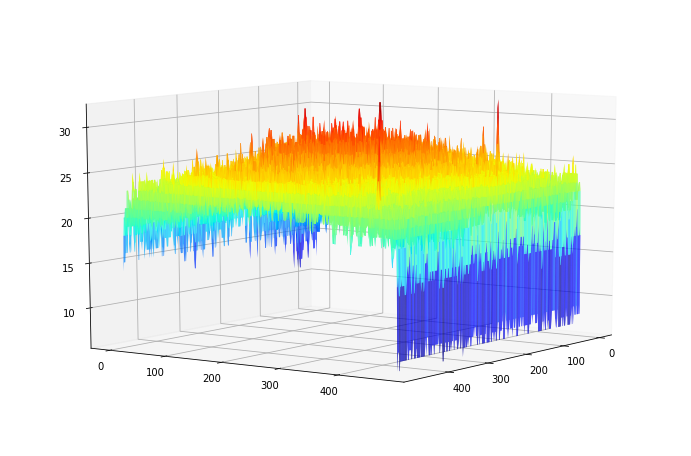

In [15]:
 
blury = scipy.misc.imresize(blur, 0.95, interp='cubic')

# create the x and y coordinate arrays (here we just use pixel indices)
xx2, yy2 = np.mgrid[0:blury.shape[0], 0:blury.shape[1]]

# create the figure
fig = plt.figure(figsize =(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(xx2, yy2, blury ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(10, 35)
fig
plt.show()

## OK ! The blured result is terrible and will not help us at all because it smothened the signal and noises are somehow enhanced, let's check another experiment.

In Next experiment , I'm going to use local histogram equalization to remove the effect of dark corners.


In [16]:
from skimage.morphology import disk
from skimage.filters import rank

selem = disk(30)
img10 = rank.equalize(img9, selem=selem)
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img10.shape[0], 0:img10.shape[1]]

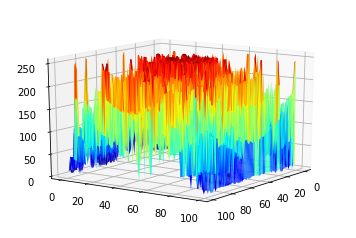

In [17]:
# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img10 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(15, 35)
fig
plt.show()

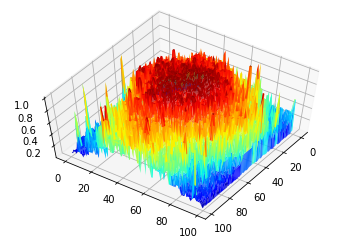

In [18]:
from skimage import exposure
# Global equalize
img_rescale = exposure.equalize_hist(img9)
# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, img_rescale ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(60, 35)
fig
plt.show()

### Not good at all! ok , let's try first bluring and then edge sharpening to see what we can do with dark corners artifact!

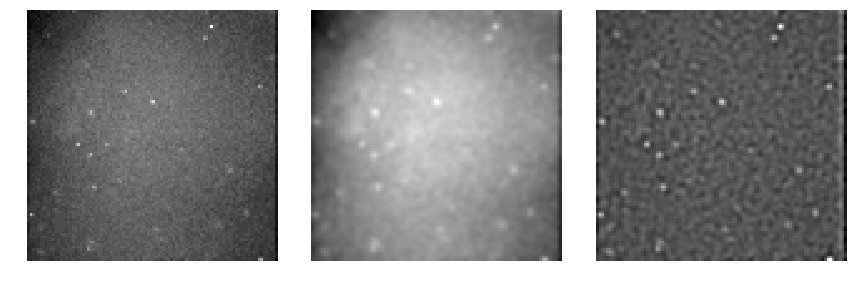

In [22]:
# Trying to blur and sharpening the image to see if any changes can
# be applied on image.

f = img9.astype(float)
blurred_f = ndimage.gaussian_filter(f, 1)

filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)

alpha = 60
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(f, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(132)
plt.imshow(blurred_f, cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
plt.imshow(sharpened, cmap=plt.cm.gray)
plt.axis('off')

plt.tight_layout()
plt.show()

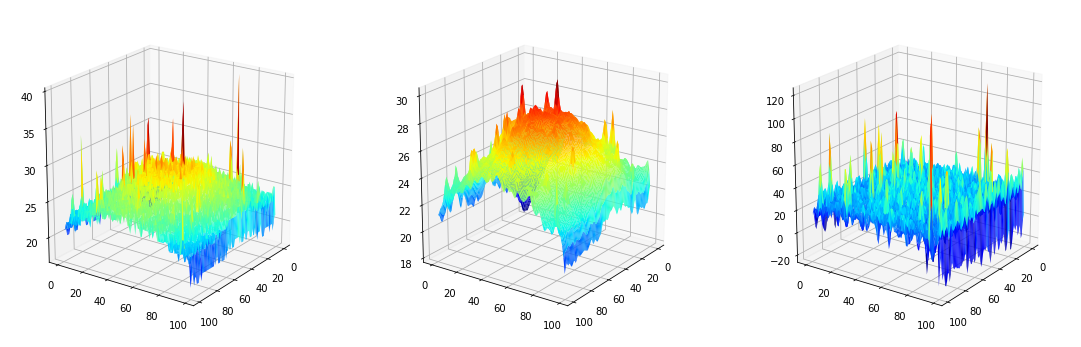

In [24]:
# create the figures
fig = plt.figure(figsize=(19, 6))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(xx, yy, f ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(xx, yy, blurred_f ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(xx, yy, sharpened ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(20, 35)

plt.show()

## OK ! It seems that we have some imrovement in the sharpened image.
### Let's take it a way and see how we can detect the points 

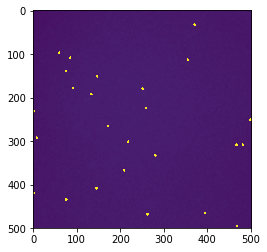

In [30]:
'''
First we are going to check if we can follow our previous strategy on 2D tracking, meaning that 
we are going to check if feature detection and tracking can help us.
Let's start with Tomasi Corners
'''
blur2 = cv2.bilateralFilter(all_ims[0][0],3,75,75)
imgob = blur2
img = blur
img2 =blur
img3 =blur

corners = cv2.goodFeaturesToTrack(imgob,25,0.01,10)
corners = np.int0(corners)
#print (corners)
#print(corners.shape)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img2,(x,y),3,255,-1)

plt.imshow(img2)
plt.show()


In [32]:
'''
Now, Let's check other features like "peak local max"
'''

blurx2 = cv2.bilateralFilter(all_ims[0][18],3,75,75)
im = blurx2
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=3, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=40)
mean_intensity = np.mean(im)
print (np.shape(im))
print ('local maxima coordinates : ' + str(coordinates))
print ('Mean = '+str(mean_intensity))
print (len(coordinates))

(500, 502)
local maxima coordinates : [[453 281]
 [439 157]
 [436  81]
 [432 401]
 [401 308]
 [382 174]
 [377 243]
 [371 108]
 [355 444]
 [334 143]
 [332 408]
 [328 184]
 [326 425]
 [325 318]
 [321 436]
 [321 254]
 [320 417]
 [318 417]
 [315 243]
 [314 420]
 [313 322]
 [310 425]
 [265 141]
 [264 295]
 [261 185]
 [240 341]
 [239 342]
 [236 419]
 [236  96]
 [206 372]
 [197 256]
 [195 256]
 [193 318]
 [184 255]
 [184 252]
 [184 251]
 [176 253]
 [176 200]
 [175 260]
 [162 120]
 [148 430]
 [146 320]
 [146 319]
 [145 319]
 [145 318]
 [128 272]
 [127 272]
 [124 221]
 [ 98 379]
 [ 91 314]
 [ 90 313]
 [ 84 309]
 [ 82 326]
 [ 77 162]
 [ 76 295]
 [ 71 168]
 [ 70 169]
 [ 60 165]
 [ 57 201]
 [ 54 197]
 [ 53 413]
 [ 53 412]
 [ 53 171]
 [ 51 267]
 [ 50 180]]
Mean = 24.8911474104
65


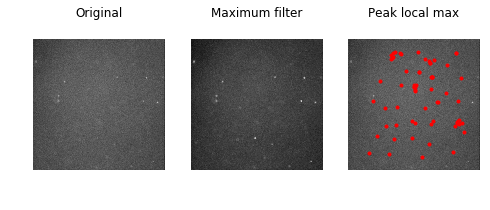

In [33]:
# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(blurx2, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

plt.show()

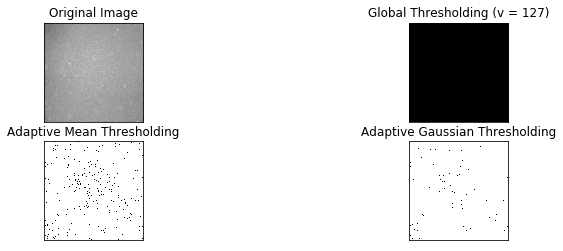

In [35]:
'''
As you see above images , the extracted points are not satisfactory for tracking and we missed some 
correct points and instead we have bunch of false positives.
'''
# Applying thresholds to see if we can do any improvements

img11 = all_ims[0][4]
img11 = cv2.medianBlur(img11,5)

ret, th1 = cv2.threshold(img11,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img11,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img11,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img11, th1, th2, th3]

fig = plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


In [109]:
img11.shape

(500, 502)

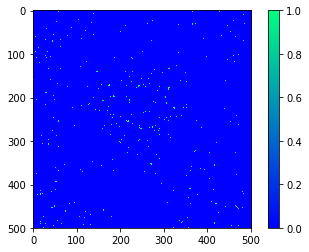

In [110]:
thr3 = abs(th3 - 255)
plt.imshow(thr3, cmap='winter')
plt.colorbar()
plt.show()

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0

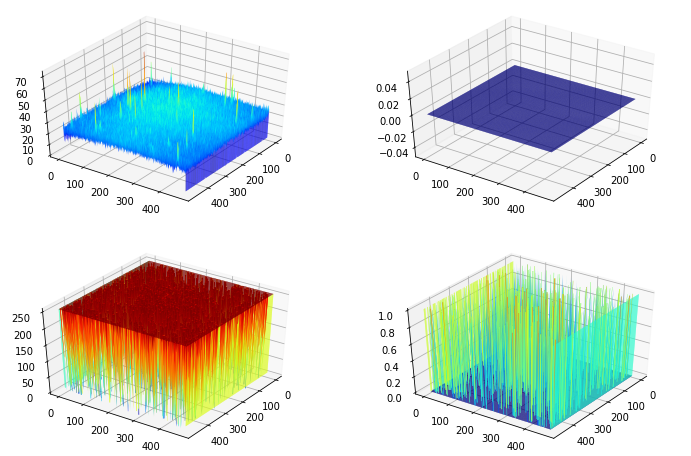

(475, 476) (500, 502)


In [31]:
# create the figure

img12 = scipy.misc.imresize(ims[5], 0.95, interp='cubic')
thr1 = scipy.misc.imresize(th1, 0.95, interp='cubic')
thr2 = scipy.misc.imresize(th2, 0.95, interp='cubic')
thr3 = scipy.misc.imresize(thr3, 0.95, interp='cubic')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(xx2, yy2, img12 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(40, 35)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(xx2, yy2, thr1 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(40, 35)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(xx2, yy2, thr2 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(40, 35)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(xx2, yy2, thr3 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(40, 35)
plt.show()

print (img12.shape, th3.shape)

In [37]:
'''
The above results are very noisy and we are not sure about keeping the correct points.
Thus, Let's change our methodology !
Now we are going to use adaptive histogram equailization to remove the effect of 
dark corners.
'''
# Load an example image
imagetiff = all_ims[0][4]

# Contrast stretching
p2, p98 = np.percentile(imagetiff, (2, 98))
img_rescale = exposure.rescale_intensity(imagetiff, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(imagetiff)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(imagetiff, clip_limit=0.03)

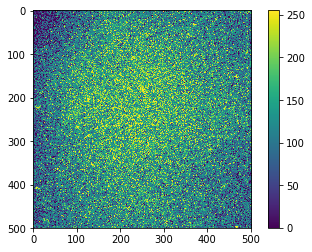

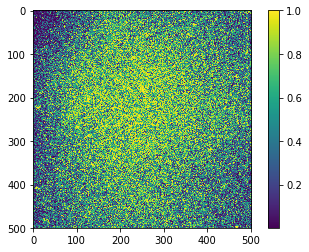

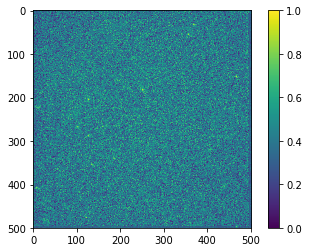

In [38]:
plt.imshow(img_rescale)
plt.colorbar()
plt.show()
plt.imshow(img_eq)
plt.colorbar()
plt.show()
plt.imshow(img_adapteq)
plt.colorbar()
plt.show()


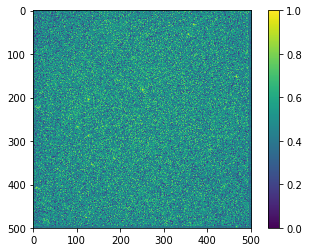

In [39]:
'''
Ok! Now it seems that improved a bit , for better potential results, let's check the logarithmic 
correction and gamma enhancement and compare the results.
'''
# Logarithmic
logarithmic_corrected = exposure.adjust_log(img_adapteq, 1)
plt.imshow(logarithmic_corrected)
plt.colorbar()
plt.show()

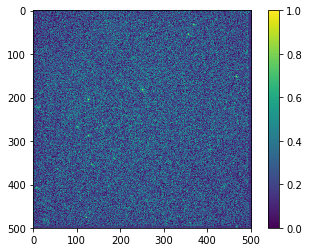

In [40]:
# Gamma
gamma_corrected = exposure.adjust_gamma(logarithmic_corrected, 2)
plt.imshow(gamma_corrected)
plt.colorbar()
plt.show()

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


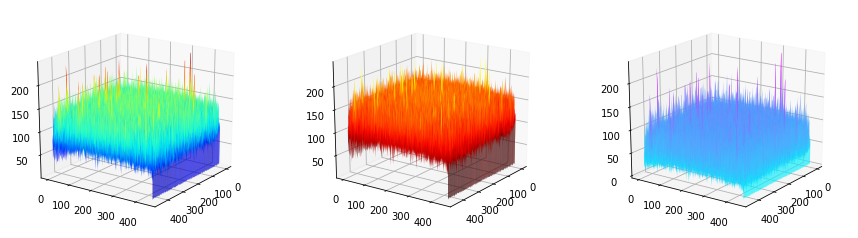

In [41]:
img_adapteq1 = scipy.misc.imresize(img_adapteq, 0.9, interp='cubic')
logarithmic_corrected1 = scipy.misc.imresize(logarithmic_corrected, 0.9, interp='cubic')
gamma_corrected1 = scipy.misc.imresize(gamma_corrected, 0.9, interp='cubic')
xx1, yy1 = np.mgrid[0:img_adapteq1.shape[0], 0:img_adapteq1.shape[1]]
# create the figure
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(xx1, yy1, img_adapteq1 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(xx1, yy1, logarithmic_corrected1 ,rstride=1, cstride=1, cmap=plt.cm.hot,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_surface(xx1, yy1, gamma_corrected1 ,rstride=1, cstride=1, cmap=plt.cm.cool,
        linewidth=0)
ax.view_init(20, 35)

plt.show()

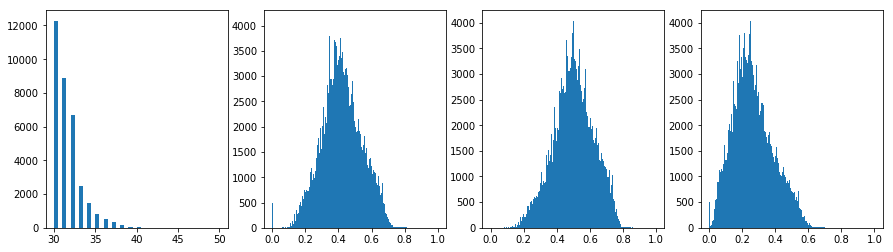

In [43]:
'''
It seems that the effect of dark corners is improved a bit but let us to apply thresholding
to see which one works better !
'''
t1 = img_adapteq
t2 = logarithmic_corrected
t3 = gamma_corrected
t4 = all_ims[0][12]

fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(1, 4, 1)
ax.hist(t4.ravel(),40,[30,50])

ax = fig.add_subplot(1, 4, 2)
ax.hist(t1.ravel(),256,[0,1])

ax = fig.add_subplot(1, 4, 3)
ax.hist(t2.ravel(),256,[0,1])

ax = fig.add_subplot(1, 4, 4)
ax.hist(t3.ravel(),256,[0,1])

plt.show()

In [44]:
t1.shape

(500, 502)

In [45]:
thresh = 0.8
t1 [ t1 <= thresh + .00] = 0
#t1 [ t1 > thresh] = 255

t2 [ t2 <= thresh + .03] = 0
#t2 [ t2 > thresh] = 255

t3 [ t3 <= thresh - .12] = 0
#t3 [ t3 > thresh] = 255

t4 [ t4 <= 40 ] = 0

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in Sc

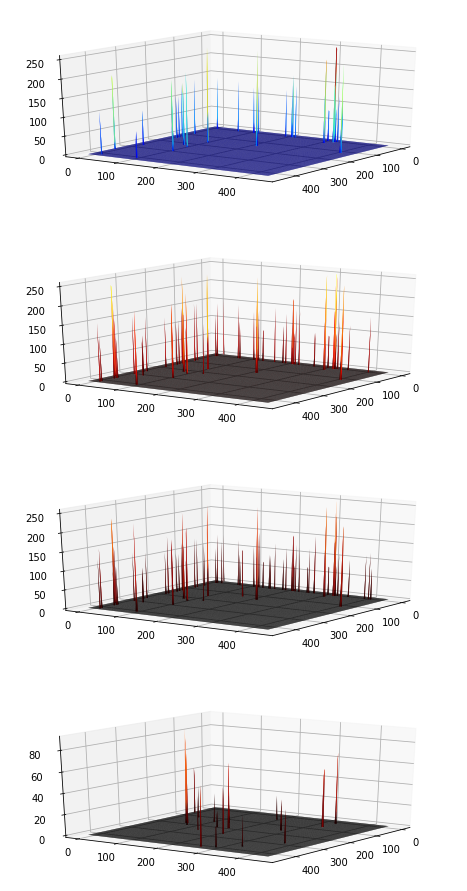

In [46]:
t12 = scipy.misc.imresize(t1, 0.9, interp='cubic')
t22 = scipy.misc.imresize(t2, 0.9, interp='cubic')
t32 = scipy.misc.imresize(t3, 0.9, interp='cubic')
t42 = scipy.misc.imresize(t4, 0.9, interp='cubic')

xx1, yy1 = np.mgrid[0:t12.shape[0], 0:t12.shape[1]]
# create the figure
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(4, 1, 1, projection='3d')
ax.plot_surface(xx1, yy1, t12 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(4, 1, 2, projection='3d')
ax.plot_surface(xx1, yy1, t22 ,rstride=1, cstride=1, cmap=plt.cm.hot,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(4, 1, 3, projection='3d')
ax.plot_surface(xx1, yy1, t32 ,rstride=1, cstride=1, cmap=plt.cm.gist_heat,
        linewidth=0)
ax.view_init(20, 35)

ax = fig.add_subplot(4, 1, 4, projection='3d')
ax.plot_surface(xx1, yy1, t42 ,rstride=1, cstride=1, cmap=plt.cm.gist_heat,
        linewidth=0)
ax.view_init(20, 35)

plt.show()

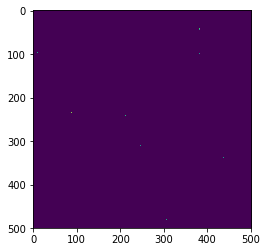

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


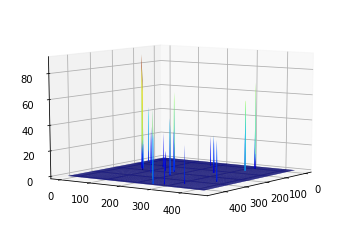

In [118]:
t5 = all_ims[0][12]

BW = np.array([i if i > 42 else 0 for i in range(0,256)]).astype(np.uint8)
img_thr = cv2.LUT(t5,BW)

plt.imshow(img_thr)
plt.show()

t52 = scipy.misc.imresize(t4, 0.9, interp='cubic')
# create the figure
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx1, yy1, t52 ,rstride=1, cstride=1, cmap=plt.cm.jet,
        linewidth=0)
ax.view_init(10, 35)
plt.show()

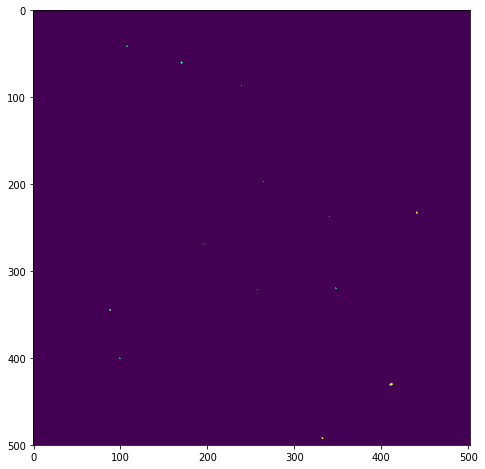

41


/Users/mojtaba/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


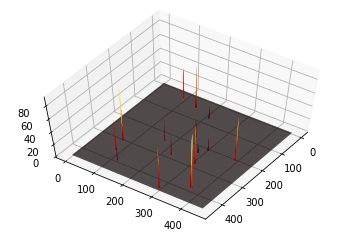

In [49]:
'''
Ok! Now let us to apply thresholding to the whole slices of one frame and create the sparse matrix 
then we will have better understanding about the position and arrangement of components per frame.
'''

total = all_ims[0]
img_thr = list ()

BW = np.array([i if i > 43 else 0 for i in range(0,256)]).astype(np.uint8)

for i in range (all_ims[0].shape[0]):
    img_thr.append(cv2.LUT(total[i],BW))
    
img_thr2 = img_thr

fig = plt.figure(figsize=(12, 8))
plt.imshow(img_thr[25])
plt.show()
print (len(img_thr2))

for i in range (len(img_thr)):
    img_thr2[i] = scipy.misc.imresize(img_thr[i], 0.9, interp='cubic')
# create the figure

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx1, yy1, img_thr2[25] ,rstride=1, cstride=1, cmap=plt.cm.hot, linewidth=0)
ax.view_init(60, 35)
plt.show()

In [52]:
img_arr = np.asarray(img_thr2)
img_arr.shape

(41, 450, 451)

In [53]:
z3, x3, y3 = img_arr.nonzero()

In [54]:
y3.shape

(5016,)

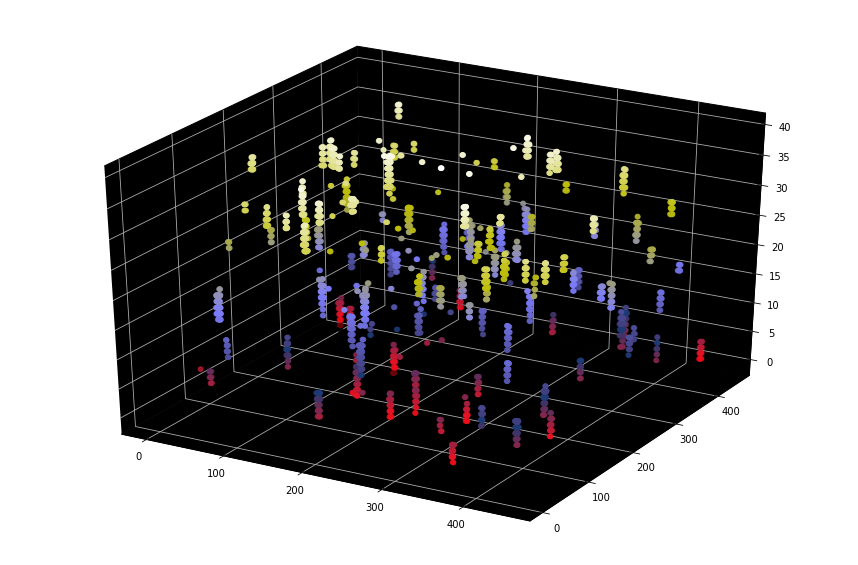

In [56]:
'''
Ok! now let us visualize the results to see if the cells are visible now or not ?
'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3, y3, z3, zdir='z3', marker = "o", c= z3, cmap='gist_stern')
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
plt.grid(False)
plt.show()
plt.savefig("demo.png", dpi=600)

#### Great ! Now the componets are visible ! 
Let's start our real work from now on !


### Step 1: Thresholding all the frames :

In [59]:
total = np.asarray(all_images)
all_img_thr = list ()
print(np.shape(all_images))

BW = np.array([i if i > 42 else 0 for i in range(0,256)]).astype(np.uint8)


(63, 41, 500, 502)


In [60]:
# Thresholding the total cells :
all_img_thr = [[]]
for i in range(total.shape[0]):
    for j in range(total.shape[1]):
        all_img_thr[i].append(cv2.LUT(total[i][j],BW))
    all_img_thr.append([])

all_img_thr = [pick for pick in all_img_thr if len(pick) > 0 ]


all_img = all_img_thr
print(np.shape(all_img_thr))

(63, 41, 500, 502)


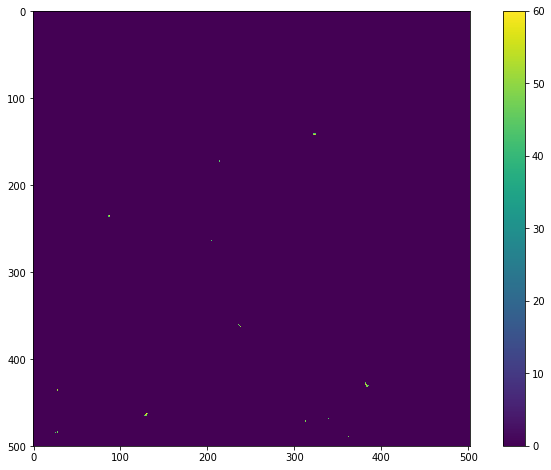

63


In [61]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(all_img_thr[24][10])
plt.colorbar()
plt.show()
print (len(all_img))



In [62]:
all_img_arr = np.asarray(all_img_thr)
all_img_arr.shape

(63, 41, 500, 502)

In [63]:
z33 = list()
x33 = list()
y33 = list()

for i in range (all_img_arr.shape[0]):
    z33.append(all_img_arr[i].nonzero()[0])
    x33.append(all_img_arr[i].nonzero()[1])
    y33.append(all_img_arr[i].nonzero()[2])

z33_arr = np.asarray(z33)
x33_arr = np.asarray(x33)
y33_arr = np.asarray(y33)



In [64]:
len(y33[24])

2258

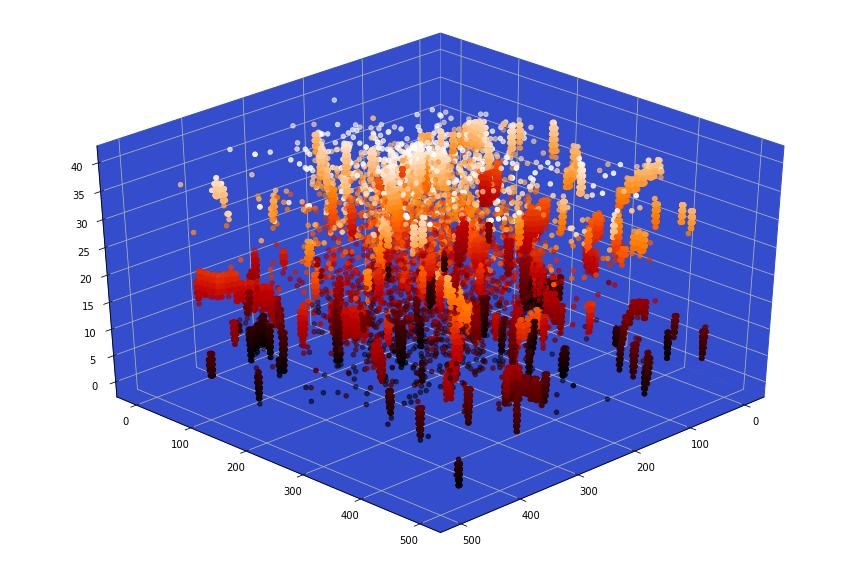

In [65]:
'''
Let us visualize all the components in a video!
'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range (62):
    ax.scatter(y33[i], x33[i], z33[i], zdir='z33[i]', marker = "o", c= z33[i], cmap='gist_heat')
ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.view_init(35, 45)
plt.grid(False)
plt.savefig("demo2-all.png", dpi=600)
plt.show()


In [129]:
x33[62].shape == y33[62].shape == z33[62].shape

True

Here we can check the sparsity degree 

In [131]:
sparsity_degree = (1 - (x33[62].shape[0] / (500*502*42) * 100))
sparsity_degree

0.9814361601214191

### Thus more than 98% of our data is 0 after thresholding ! That shows we can work on a distributed pipeline to do the computations

In [67]:
'''
Now let's take a look at our ground truth and compare our results with that !
'''
from numpy import genfromtxt
my_data = genfromtxt('/Users/mojtaba/Desktop/a/ca41e00028525edd02f0b0b7b815fbef4e469d8af6e8cfcdc62dd65e2d453a16/metadata/010_Position_GT.csv', delimiter=',')

In [68]:
my_data = my_data.T

In [69]:
xx33 = my_data[0]
yy33 = my_data[1]
zz33 = my_data[2]


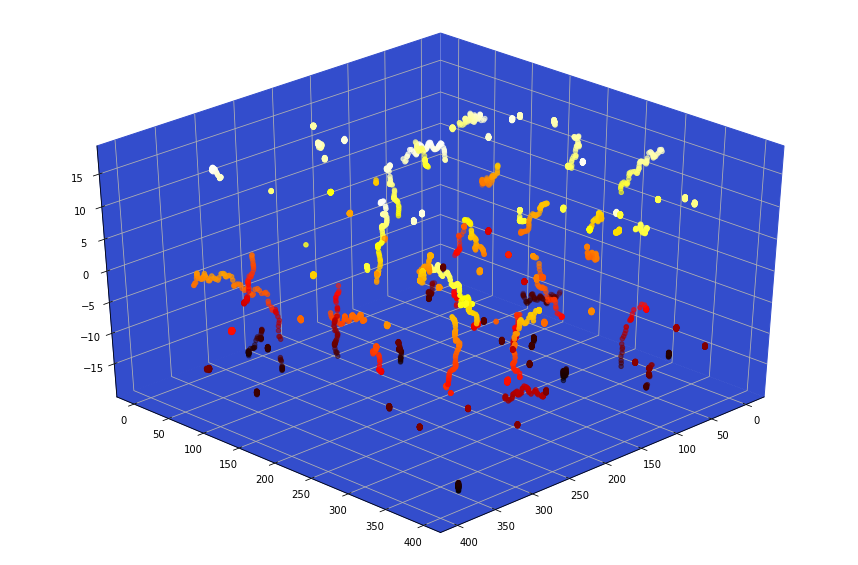

In [70]:
# here we are going to visualize the ground truth
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xx33, yy33, zz33, zdir='zz33', marker = "o", c= zz33, cmap='hot')
ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.view_init(35, 45)
plt.grid(False)
plt.savefig("demo2-GT.png", dpi=600)
plt.show()


## OK. as it is visible our results are very similar to the ground truth ( somehow a super class of the ground truth ) to get more closer to the ground truth, we need to do 2 steps :
1. extracting the points as components
2. using the centers of the components as instead of the whole component  
3. removing the noise from our results.

### Step 2 : applying 3d connected component labeling  

In [72]:
from scipy.ndimage.measurements import label

array = img_arr
structure = np.ones((3,3,3), dtype = np.int)
structure

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [ ]:
labeled, ncomponents = label(array, structure)


In [134]:
array.nonzero()
print(ncomponents)

177


In [75]:
labeled.shape

(41, 450, 451)

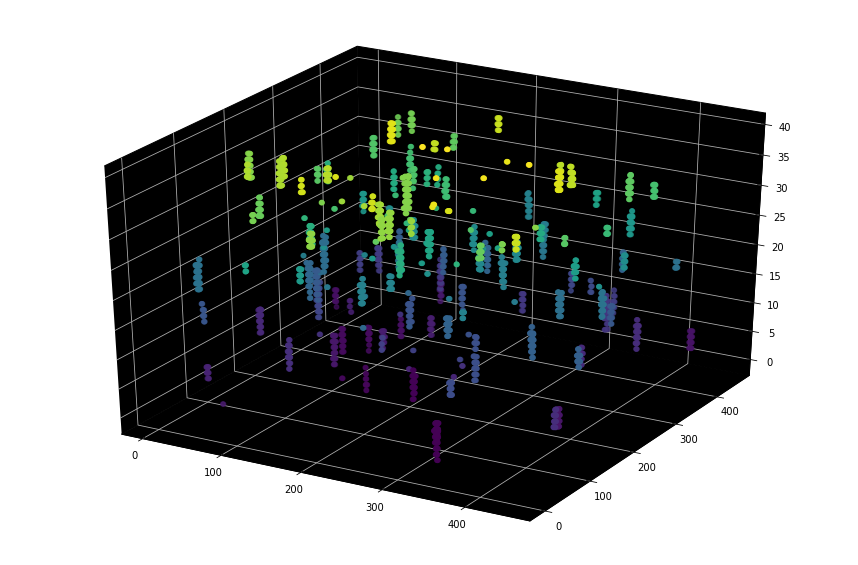

In [77]:
# now let us visualize the components in first frame

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(yn3, xn3, zn3, zdir='zn3', marker = "o", c= labeled[zn3, xn3, yn3])
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
plt.grid(False)
plt.savefig("demo2.png", dpi=600)
plt.show()

### Step 3 : extracting the center of masses : 

### First, I want to extract and visualize the center of the points for frame 0  

In [79]:
centers = list ()
centers.append(ndimage.measurements.center_of_mass(array, labeled))

In [85]:
from scipy.ndimage.measurements import center_of_mass
centers = center_of_mass(array, labels=labeled, index=range(1, ncomponents))

In [90]:
print(len(centers))
print(centers[100][0]) # Z, X, Y

176
24.0


In [92]:
unique, counts = np.unique(labeled, return_counts = True)
dict(zip(unique, counts))

{0: 8315934,
 1: 75,
 2: 64,
 3: 38,
 4: 20,
 5: 4,
 6: 50,
 7: 36,
 8: 29,
 9: 34,
 10: 43,
 11: 42,
 12: 62,
 13: 35,
 14: 2,
 15: 37,
 16: 30,
 17: 14,
 18: 20,
 19: 4,
 20: 4,
 21: 63,
 22: 33,
 23: 64,
 24: 33,
 25: 48,
 26: 4,
 27: 4,
 28: 4,
 29: 83,
 30: 31,
 31: 68,
 32: 60,
 33: 23,
 34: 29,
 35: 12,
 36: 3,
 37: 3,
 38: 96,
 39: 28,
 40: 4,
 41: 15,
 42: 35,
 43: 42,
 44: 21,
 45: 4,
 46: 54,
 47: 36,
 48: 23,
 49: 34,
 50: 4,
 51: 68,
 52: 41,
 53: 31,
 54: 35,
 55: 65,
 56: 32,
 57: 53,
 58: 53,
 59: 74,
 60: 4,
 61: 4,
 62: 3,
 63: 4,
 64: 105,
 65: 68,
 66: 20,
 67: 95,
 68: 4,
 69: 61,
 70: 49,
 71: 31,
 72: 4,
 73: 4,
 74: 4,
 75: 36,
 76: 3,
 77: 64,
 78: 46,
 79: 61,
 80: 12,
 81: 31,
 82: 3,
 83: 45,
 84: 53,
 85: 46,
 86: 51,
 87: 27,
 88: 21,
 89: 4,
 90: 4,
 91: 3,
 92: 4,
 93: 2,
 94: 34,
 95: 52,
 96: 27,
 97: 4,
 98: 3,
 99: 30,
 100: 3,
 101: 4,
 102: 4,
 103: 24,
 104: 11,
 105: 67,
 106: 4,
 107: 3,
 108: 31,
 109: 29,
 110: 16,
 111: 68,
 112: 45,
 113: 33

In [94]:
x3d = list()
y3d = list()
z3d = list()
for i in range (len(centers)):
    z3d.append(centers[i][0])
    x3d.append(centers[i][1])
    y3d.append(centers[i][2])
x3d = np.asarray(x3d)
y3d = np.asarray(y3d)
z3d = np.asarray(z3d)

In [95]:
print(z3d[5], y3d[5], x3d[5])


4.16722783389 91.1750841751 239.7003367


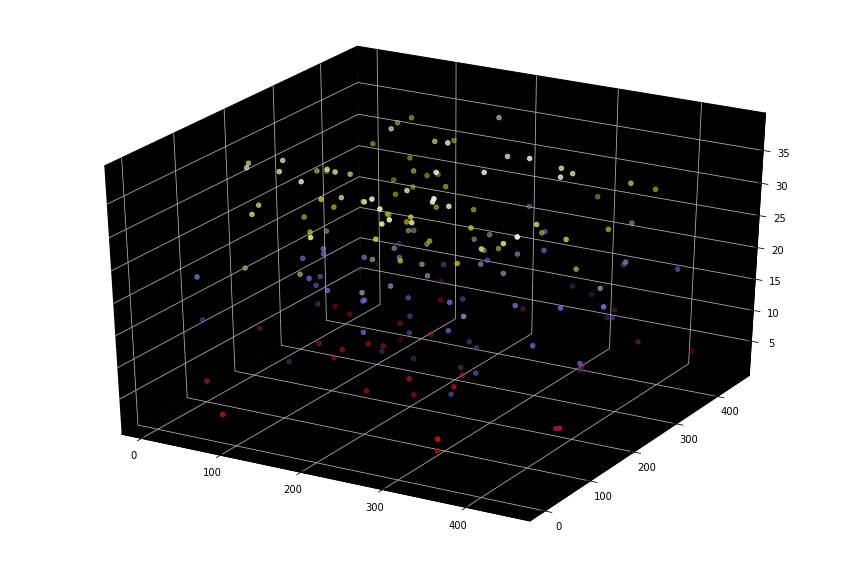

In [96]:
# Visualizing the centers for frame 0
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y3d, x3d, z3d, zdir='z3d', marker = "o", c= z3d, cmap='gist_stern')
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
plt.grid(False)
plt.savefig("demo2.png", dpi=600)
plt.show()

## Ok ! now lets extract all the centers and visualize them 

In [170]:
'''
First we extract the labels of the componets for all the cells
across all the frames. Thus the number of components and their labels
are discovered here:
'''
all_labeled = np.zeros(shape=(63, 41, 500, 502))
all_ncomponents = np.zeros(all_img_arr.shape[0])
for frames in range (all_img_arr.shape[0]): 
    all_labeled[frames], all_ncomponents[frames] = label(all_img_arr[frames], structure)


In [98]:
print(all_ncomponents)

[ 256.  256.  289.  292.  282.  267.  254.  247.  249.  203.  191.  225.
  209.  217.  218.  207.  230.  189.  191.  192.  203.  207.  163.  152.
  149.  153.  158.  143.  155.  160.  152.  155.  157.  154.  147.  149.
  138.  144.  146.  146.  142.  155.  144.  171.  178.  168.  169.  170.
  171.  153.  166.  148.  159.  161.  161.  157.  163.  160.  168.  160.
  164.  157.  158.]


In [ ]:
'''
Now let's extract all the centers across all the frames.
comment: I changed my previous way that was very slow, thus the the 
computation time reduced from 7 hours to only 5 mins !
'''

all_centers2 = []
for frames in range (all_img_arr.shape[0]):
    all_centers2.append(center_of_mass(all_img_arr[frames], 
                        labels=all_labeled[frames], 
                        index=range(1, int(all_ncomponents[frames]))))

In [109]:
print(len(all_centers2), len(all_centers2[0]))

63 255


In [110]:
print(len(all_centers2))
all_centers2 = np.asarray(all_centers2)
np.save('all_centers_fast.npy', all_centers2)

63


In [161]:
all_centers = np.load('all_centers_fast.npy')
all_centers = [pick for pick in all_centers if len(pick) > 0 ]
print(len(all_centers))

63


In [162]:
len(all_centers[0])

255

In [163]:
all_centers[0][0][0]

3.5428253615127918

In [164]:
zn3d = [[]]
xn3d = [[]]
yn3d = [[]]

for frames in range(len(all_centers)):
    for i in range (len(all_centers[frames])):
        zn3d[frames].append(all_centers2[frames][i][0])
        xn3d[frames].append(all_centers2[frames][i][1])
        yn3d[frames].append(all_centers2[frames][i][2])
    zn3d.append([])
    xn3d.append([])
    yn3d.append([])
    

In [165]:
len(yn3d[0])

255

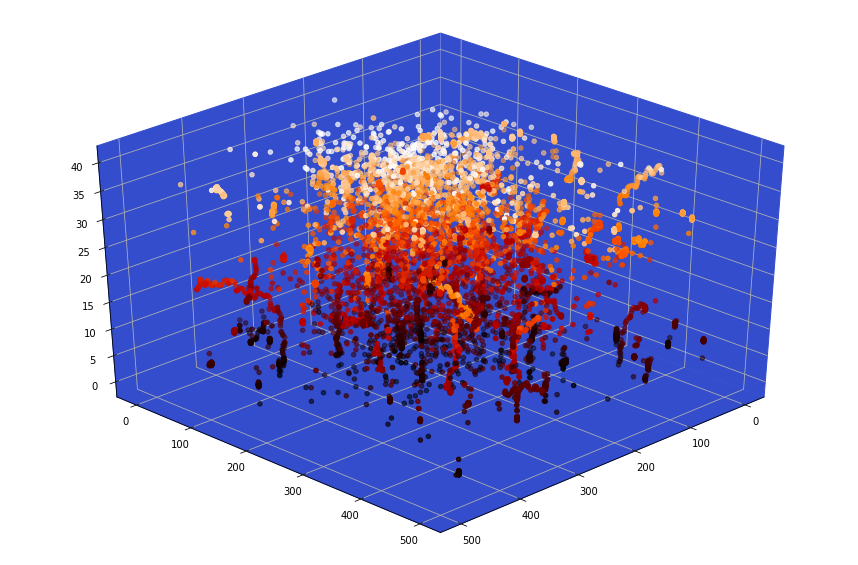

In [119]:
# Visualizing the centers :

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(all_img_arr.shape[0]):
    ax.scatter(yn3d[i], xn3d[i], zn3d[i], 
               zdir='zn3d[i]', marker = "o",  c= zn3d[i], cmap='gist_heat')

ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.view_init(35, 45)
plt.savefig("demo2center-all.png", dpi=600)
plt.show()

### Step 4 : Removing the noise : 

In [122]:
print(np.shape(labeled), np.shape(all_labeled), np.shape(all_centers2))

(41, 450, 451) (63, 41, 500, 502) (63,)


In [166]:
'''
For Removing the noise,, i've considered only the components with 
the volume greater tha 1 pixel. Thus first I computed the volume of 
each component and then extracted the centers only for the components 
with the volume greater than 1 pixels:
'''
unique = list()
counts = list()
for frames in range(all_img_arr.shape[0]):
    unique.append(np.unique(all_labeled[frames], return_counts = True)[0])
    counts.append(np.unique(all_labeled[frames], return_counts = True)[1])
#components_volume[frames] = dict(zip(unique, counts))


In [141]:
all_ncomponents[0]

256.0

In [167]:
# Here I'm selecting only the center of the components with the volume 
# less than 1 pixel and put them in thr_idxs list  :
thr_idxs = [[]]
for i in range (len(counts)):
    for j in range (len (counts[i])):
        if counts[i][j] > 1 : 
            thr_idxs[i].append(unique[i][j])
    thr_idxs.append([])
thr_idxs = [pick for pick in thr_idxs if len(pick) > 0 ]
print(len(thr_idxs),len(thr_idxs[0]))


63 119


In [168]:
all_centers_noisefree2 = []
for frames in range (all_img_arr.shape[0]):
    all_centers_noisefree2.append(center_of_mass(all_img_arr[frames], 
                            labels=all_labeled[frames], 
                            index= thr_idxs[frames]))

/Users/mojtaba/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


In [153]:
len(all_centers_noisefree2)

63

In [169]:
all_centers_noisefree2 = [pick for pick in all_centers_noisefree2 if len(pick) > 0 ]
np.save('all_cnf_fast2.npy', all_centers_noisefree2)
print(len(all_centers_noisefree2))

63


In [156]:
all_centers_noisefree2 = np.asarray(all_centers_noisefree2)
print(np.shape(all_centers_noisefree2), np.shape(all_centers_noisefree2[61])[0], np.shape(all_centers_noisefree2[0][0]))

(63,) 114 (3,)


In [158]:
znf3d = [[]]
xnf3d = [[]]
ynf3d = [[]]

for frames in range(all_img_arr.shape[0]):
    for i in range (np.shape(all_centers_noisefree2[frames])[0]):
        znf3d[frames].append(all_centers_noisefree2[frames][i][0])
        xnf3d[frames].append(all_centers_noisefree2[frames][i][1])
        ynf3d[frames].append(all_centers_noisefree2[frames][i][2])
    znf3d.append([])
    xnf3d.append([])
    ynf3d.append([])
    

In [159]:
len(ynf3d[0])

119

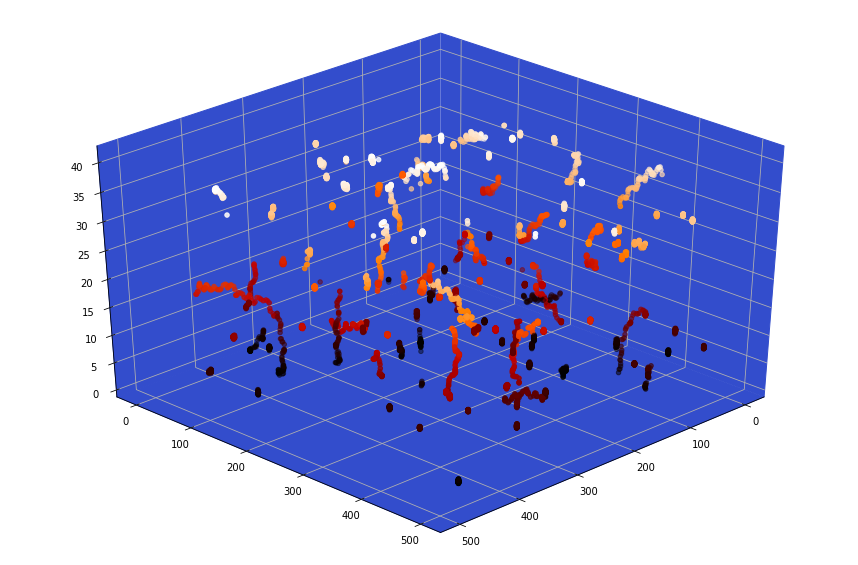

In [160]:
# ok! Now let us visualize the final detection results:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(all_img_arr.shape[0]):
    ax.scatter(ynf3d[i], xnf3d[i], znf3d[i], 
               zdir='znf3d[i]', marker = "o",  c= znf3d[i], cmap='gist_heat')

ax.w_xaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_yaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.w_zaxis.set_pane_color((0.2, 0.3, 0.8, 1.0))
ax.view_init(35, 45)
plt.grid(False)
plt.savefig("demo2center-allnf.png", dpi=600)
plt.show()